In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from sympy.core.compatibility import (iterable, is_sequence, ordered,
    default_sort_key, range)

In [61]:
%matplotlib notebook
init_session()

IPython console for SymPy 1.2 (Python 3.6.8-64-bit) (ground types: gmpy)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at http://docs.sympy.org/1.2/



In [62]:
def ode_rewrite(ode, fun, x):
    """
    Rewrite an system of ODEs isolating the highest derivatives
    """
    if not iterable(ode):
        ode = [ode]
        fun = [fun]
    orders = [ode_order(eq, f(x)) for eq, f in zip(ode, fun)]
    ode_aux = []
    old_var = []
    diff_order = []
    for cont, eq in enumerate(ode):
        f = fun[cont]
        order = orders[cont]
        ode_aux.append(solve(eq, f(x).diff(x, order))[0])
        for cont_diff in range(orders[cont]):
            old_var.append(diff(f(x), x, cont_diff))
            diff_order.append(ode_order(old_var[-1], f(x)))

    return orders, ode_aux, old_var, diff_order

In [63]:
def ode2sys(ode, fun, x):
    """
    Rewrite an system of ODEs of order n as n equations
    of order 1
    """
    if not iterable(ode):
        ode = [ode]
        fun = [fun]
    orders, ode, old_var, diff_order = ode_rewrite(ode, fun, x)
    u = symbols("u:{}".format(sum(orders)))
    #subs = zip(old_var[::-1], u[::-1])
    subs = [(a, b) for _, a, b in sorted(zip(diff_order, old_var, u),
                                     key=lambda val: val[0], reverse=True)]
    sys = []
    cont_var = 1
    for cont, eq in enumerate(ode):
        sys = sys + list(u[cont_var:cont_var + orders[cont] - 1])
        sys.append(eq.subs(subs))
        cont_var = cont_var + orders[cont]
    return u, sys

In [64]:
def critical_points(ode, fun, x):
    """Find critical points of an ODE"""
    u, sys = ode2sys(ode, fun, x)
    sol = solve(sys, u)
    return sol

In [65]:
def classify_critical_points(ode, fun, x):
    """Classify stability for critical points for 2D systems"""
    u, sys = ode2sys(ode, fun, x)
    sol = solve(sys, u)
    A = Matrix(sys).jacobian(u)
    stab = {xc: None for xc in sol}
    for xc in sol:
        B = A.subs({u[k]: xc[k] for k in range(len(u))})
        trace = B.trace()
        det = B.det()
        if det < 0:
            stab[xc] = "saddle"
        elif trace == 0:
            stab[xc] = "center"
        elif det > trace**2/4:
            if trace > 0:
                stab[xc] = "unstable spiral"
            else:
                stab[xc] = "stable spiral"
        else:
            if trace > 0:
                stab[xc] = "unstable node"
            else:
                stab[xc] = "stable node"
    return stab

In [66]:
def plotdf(ode, fun, x, xlim=(-5, 5), ylim=(-5, 5), nx=51, ny=51,
           args={None: None}, ax=None):
    """
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        
    u, sys = ode2sys(ode, fun, x)
    u_fun = lambdify(u, sys[0].subs(args), "numpy")
    v_fun = lambdify(u, sys[1].subs(args), "numpy")

    Y, X = np.mgrid[ylim[0]:ylim[1]:ny*1j, xlim[0]:xlim[1]:nx*1j]
    U = u_fun(X, Y)
    V = v_fun(X, Y)
    ax.streamplot(X, Y, U, V)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    return ax

## Simple pendulum

In [67]:
f = symbols("f", cls=Function)
x = symbols("x")
ode = f(x).diff(x, 2) + sin(f(x))
u, sys = ode2sys(ode, f, x)

In [68]:
sys

<IPython.core.display.Javascript object>


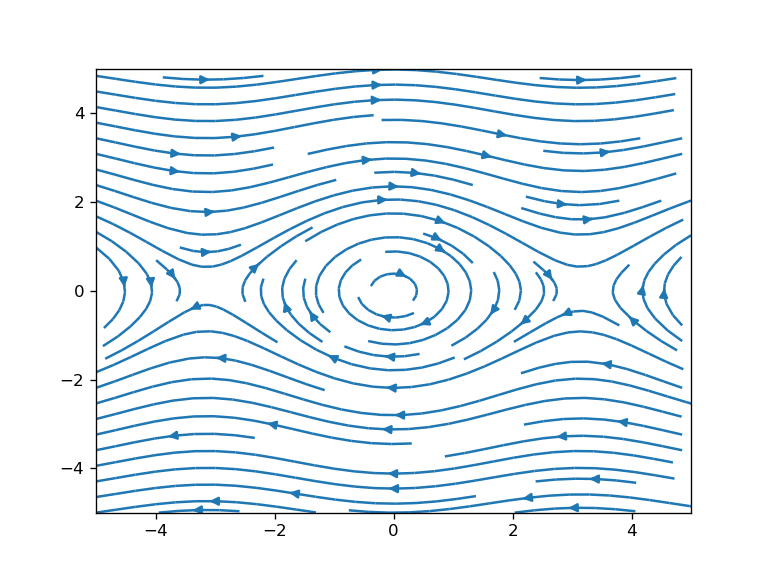

In [69]:
plotdf(ode, f, x)

In [70]:
critical_points(ode, f, x)

In [71]:
classify_critical_points(ode, f, x)

{(0, 0): 'center', (pi, 0): 'saddle'}

## Fourth order differential equation

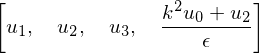

In [72]:
f = symbols("f", cls=Function)
x, k, eps = symbols("x k epsilon")
ode = f(x).diff(x, 2) - eps*f(x).diff(x, 4) + k**2*f(x)
u, sys = ode2sys(ode, f, x)
sys

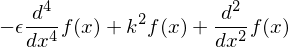

In [73]:
ode

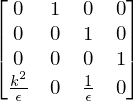

In [74]:
A = Matrix(sys).jacobian(u)
A

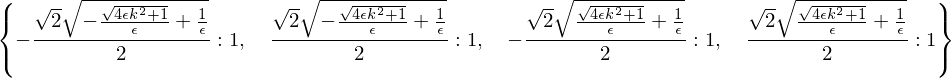

In [75]:
A.eigenvals()

## Conserved quantity

In [76]:
ode = f(x).diff(x, 2) - f(x)**5 + f(x)
u, sys = ode2sys(ode, f, x)
sys

In [77]:
sol = solve(sys, u)
sol

In [78]:
stab_pts = classify_critical_points(ode, f, x)
stab_pts

{(-1, 0): 'saddle',
 (0, 0): 'center',
 (1, 0): 'saddle',
 (-I, 0): 'saddle',
 (I, 0): 'saddle'}

<IPython.core.display.Javascript object>


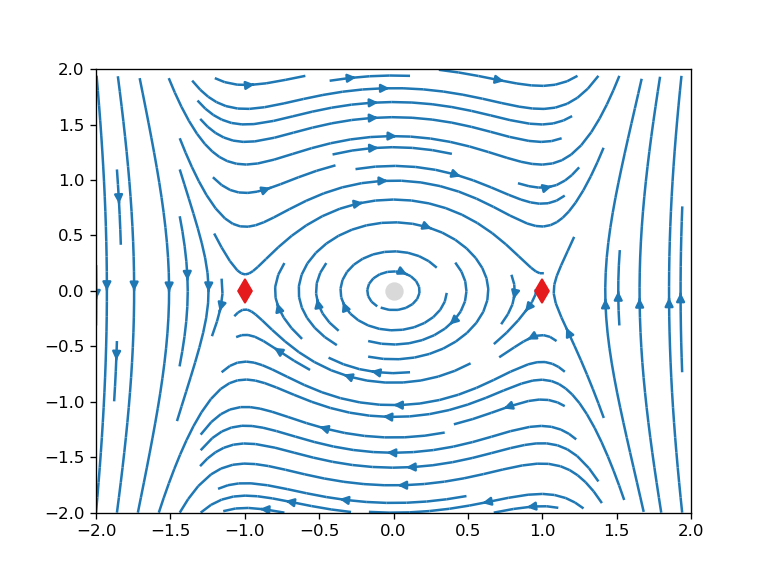

In [79]:
fig, ax = plt.subplots(1, 1)
ax = plotdf(ode, f, x, xlim=(-2, 2), ylim=(-2, 2), ax=ax)
markers = {
    "saddle": "d",
    "center": "o",
    "unstable spiral": "S",
    "stable spiral": "S",
    "unstable node": "D",
    "stable node": "D"}
marker_colors = {
    "saddle": "#e41a1c",
    "center": "#d9d9d9",
    "unstable spiral": "#e41a1c",
    "stable spiral": "#377eb8",
    "unstable node": "#e41a1c",
    "stable node": "#377eb8"}
for pt in sol:
    pt_x, pt_y = pt
    stab = stab_pts[pt]
    if pt_x.is_real and pt_y.is_real:
        ax.plot(pt_x, pt_y, marker=markers[stab], color=marker_colors[stab],
               markersize=10)

## Nonlinear nonhomogeneous second derivative

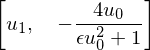

In [80]:
ode = f(x).diff(x, 2) + 4*f(x) + eps*f(x)**2*f(x).diff(x, 2)
u, sys = ode2sys(ode, f, x)
sys

<IPython.core.display.Javascript object>


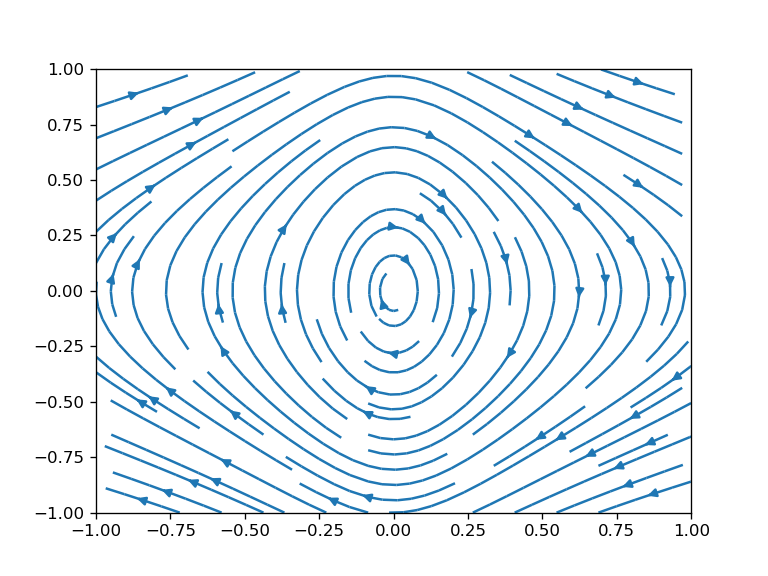

In [81]:
fig, ax = plt.subplots(1, 1)
plotdf(ode, f, x, xlim=(-1, 1), ylim=(-1, 1), args={eps: 10}, ax=ax)

## Coupled equation

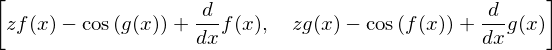

In [82]:
eq =  [f(x).diff(x) - cos(g(x)) + z*f(x), g(x).diff(x) - cos(f(x)) + z*g(x)]
eq

In [83]:
u, sys = ode2sys(eq, [f, g], x)
sys

## Lotka-Volterra

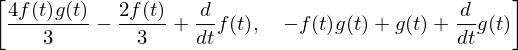

In [84]:
eq =  [f(t).diff(t) - 2*f(t)/3 + 4*f(t)*g(t)/3, g(t).diff(t) - f(t)*g(t) + g(t)]
eq

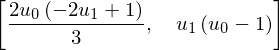

In [85]:
u, sys = ode2sys(eq, [f, g], t)
sys

<IPython.core.display.Javascript object>


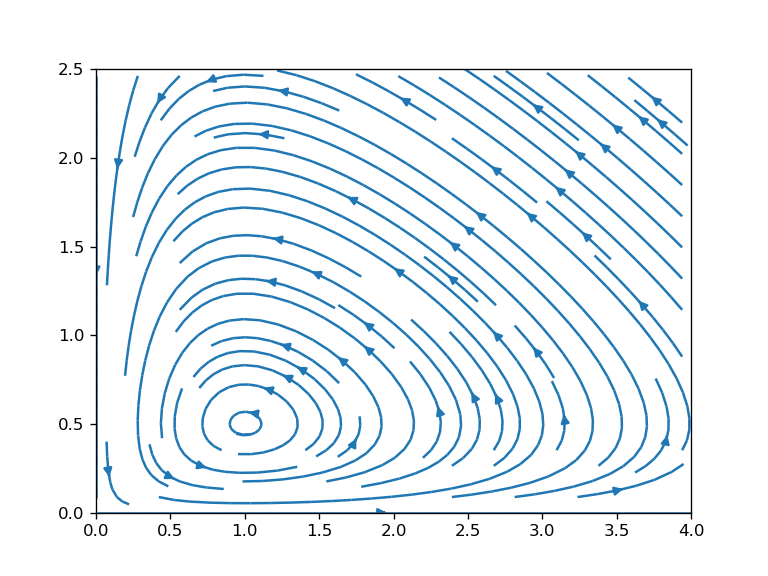

In [86]:
fig, ax = plt.subplots(1, 1)
plotdf(eq, [f, g], t, xlim=(0, 4), ylim=(0, 2.5), ax=ax)